In [1]:
# ! pip install geopandas

In [2]:
# ! pip install mapclassify

In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import geopandas as gpd
from matplotlib import cm
%matplotlib inline

In [4]:
df = pd.read_csv('data/opportunities.csv',low_memory=False)
df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [5]:
df.Region.value_counts()

Japan          4892
EMEA           4664
Americas       3945
APAC           3262
Middle East     184
Name: Region, dtype: int64

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [7]:
#agrego singapore que no esta en el df world
singapore = gpd.read_file('Maps/Singapore_AL2-AL2.shp')
singapore = singapore.loc[:,["name","country","geometry"]]
singapore.columns = ["name","iso_a3","geometry"]
singapore["continent"] = "Asia"
singapore.head()

,name,iso_a3,geometry,continent
0,Singapore,SGP,"MULTIPOLYGON (((103.74070 1.15869, 103.74065 1...",Asia


In [8]:
df_geo = df.loc[:,["Opportunity_ID","Stage","Region","Territory","Billing_Country"]]
df_geo['Billing_Country'] = df_geo['Billing_Country'].fillna(df['Territory'])
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("United States", "United States of America")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Korea, Republic of", "South Korea")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Korea, Democratic People's Republic of", "North Korea")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Reunion", "France")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Macedonia, the former Yugoslav Republic of", "Macedonia")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Bosnia and Herzegovina", "Bosnia and Herz.")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Dominican Republic", "Dominican Rep.")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Viet Nam", "Vietnam")
df_geo['Billing_Country'] = df_geo['Billing_Country'].replace("Czech Republic", "Czechia")
df_geo["Territory"] = df_geo["Territory"].replace("None",np.NaN)
df_geo["Region"] = df_geo["Region"].replace("None",np.NaN)
df_geo["Billing_Country"] = df_geo["Billing_Country"].replace("None",np.NaN)
df_geo = df_geo.groupby("Billing_Country").agg({"Opportunity_ID":"count","Region":"first","Territory":"first"}).reset_index()
df_geo = df_geo.rename(columns={"Opportunity_ID":"count"})
df_geo.head()

,Billing_Country,count,Region,Territory
0,Albania,2,EMEA,Albania
1,Argentina,1,Americas,SE America
2,Armenia,2,EMEA,Armenia
3,Australia,1169,APAC,Australia
4,Austria,145,EMEA,Austria


In [9]:
def region(x):
    if x["Region"] is np.NaN:
        if x.continent == "Africa" or x.continent == "Europe":
            return "EMEA"
        elif x.continent == "Asia" or x.continent == "Oceania":
            return "APAC"
        elif x.continent == "North America" or "South America":
            return "Americas"
        return None
    return  x["Region"]

In [10]:
dfmerge = world.merge(how="left",right=df_geo,right_on="Billing_Country",left_on="name")
dfmerge["Region"] = dfmerge.apply(region, axis=1)
dfmerge["count"] = dfmerge.groupby("Region")["count"].transform("sum").fillna(0)
dfmerge.nlargest(1,"count")

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Billing_Country,count,Region,Territory
155,126451398,Asia,Japan,JPN,4932000.0,"MULTIPOLYGON (((141.88460 39.18086, 140.95949 ...",Japan,4879.0,Japan,Japan


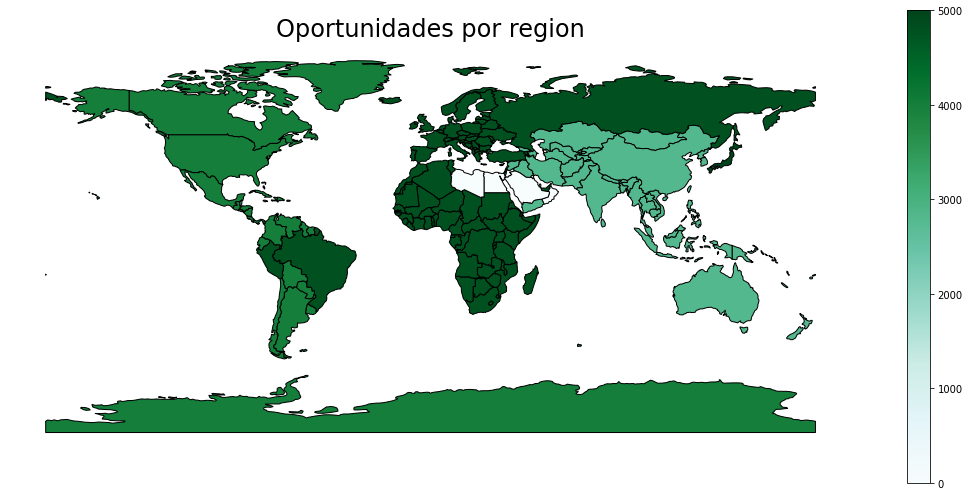

In [11]:
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.axis('off')
plt.title('Oportunidades por region',size=24)

sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=0, vmax=5000))
cbar = fig.colorbar(sm)

dfmerge.plot(column='count', cmap='BuGn', ax=ax,edgecolor='black')
plt.tight_layout()
#plt.savefig("pngs/mapa-op-region.png")

In [12]:
dfmerge_territory = world.merge(how="left",right=df_geo,right_on="Billing_Country",left_on="name")
dfmerge_territory["count"] = dfmerge_territory.groupby("Territory")["count"].transform("sum").fillna(np.NaN)
dfmerge_territory.head(1)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Billing_Country,count,Region,Territory
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN


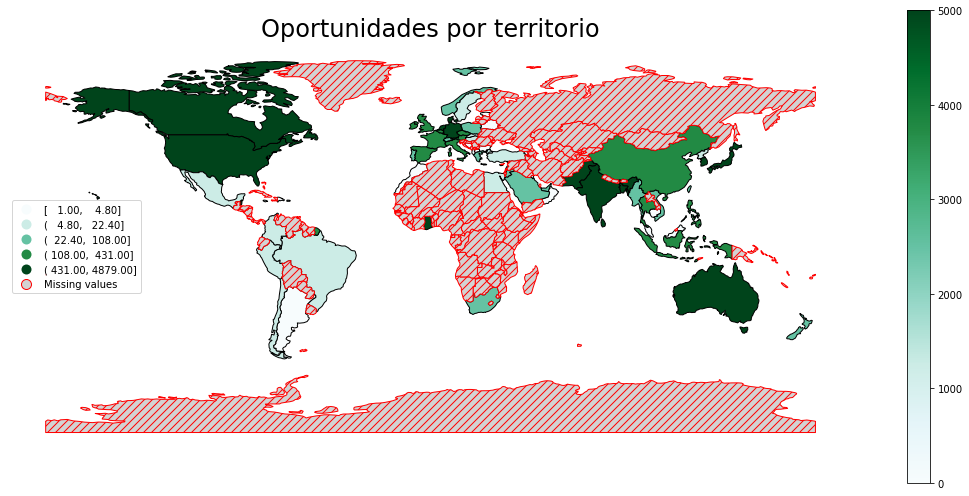

In [13]:
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.axis('off')
plt.title('Oportunidades por territorio',size=24)

sm = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=0, vmax=5000))
cbar = fig.colorbar(sm)

dfmerge_territory.plot(column='count', cmap='BuGn', ax=ax,edgecolor='black', 
                       scheme="quantiles",figsize=(15, 10),legend=True,
                        legend_kwds={'loc': 'center left'},
                    missing_kwds={
                         "color": "lightgrey",
                         "edgecolor": "red",
                         "hatch": "///",
                          "label": "Missing values",
      },
  )

plt.tight_layout()
#plt.savefig("pngs/mapa-op-territory.png")

In [14]:
# world.plot(
#       column="pop_est",
#     legend=True,
#      scheme="quantiles",
     
#     figsize=(15, 10),
#       missing_kwds={
#          "color": "lightgrey",
#          "edgecolor": "red",
#          "hatch": "///",
#           "label": "Missing values",
#       },
#   );